# Implementation of Grover's algorithm

If needed - Qiskit setup can be found here: https://quantum.cloud.ibm.com/docs/en/guides/cloud-setup

In [15]:
import math

from qiskit import QuantumCircuit
from qiskit.circuit.library import GroverOperator, MCMTGate, XGate, ZGate
from qiskit.visualization import plot_distribution

from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2 as Sampler

In [17]:
#QiskitRuntimeService.save_account(
#token="<token>",
#instance="<CRN>",
#overwrite=True
#)

In [5]:
oracle = QuantumCircuit(4, name="oracle")
oracle.x(2)
oracle.x(1)
oracle.compose(MCMTGate(ZGate(), 3, 1), inplace=True)
oracle.x(2)
oracle.x(1)

oracle.draw()

1-Z      
q_0: ───────■───────
     ┌───┐  │  ┌───┐
q_1: ┤ X ├──■──┤ X ├
     ├───┤  │  ├───┤
q_2: ┤ X ├──■──┤ X ├
     └───┘  │  └───┘
q_3: ───────■───────

Let's see how this oracle works by applying it to the state we look for and some other state.
We look for state 1001, so let's start with it first:

In [7]:
from qiskit.quantum_info import Statevector

state = Statevector.from_label('1001')
state = state.evolve(oracle)
state.draw('latex')

<IPython.core.display.Latex object>

It was correctly multiplied by -1. - as we need.
Now let's show that it leaves other states untached, let's use 1011 as an example, but you can experiment with any state:

In [8]:
state = Statevector.from_label('1011')
state = state.evolve(oracle)
state.draw('latex')

<IPython.core.display.Latex object>

In [18]:
service = QiskitRuntimeService(channel="ibm_quantum_platform")
backend = service.least_busy(operational=True, simulator=False)
backend.name

'ibm_torino'

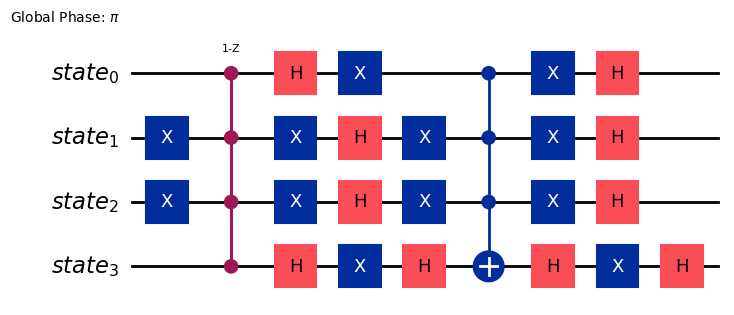

In [19]:
grover_op = GroverOperator(oracle)
grover_op.decompose().draw(output="mpl", style="iqp")

In [20]:
optimal_num_iterations = math.floor(math.pi / (4 * math.asin(math.sqrt(1 / 2**grover_op.num_qubits))))
print(optimal_num_iterations)

3


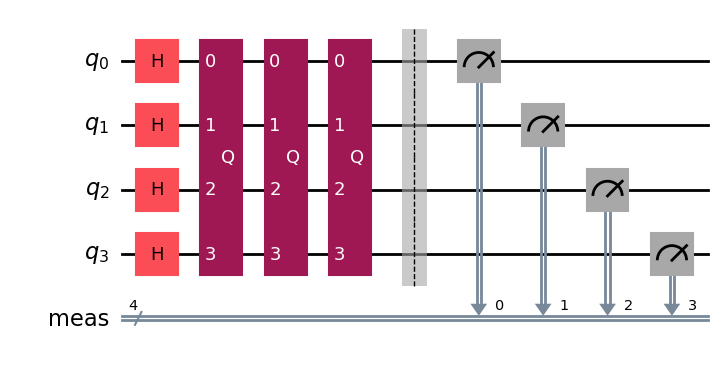

In [21]:
qc = QuantumCircuit(grover_op.num_qubits)
qc.h(range(grover_op.num_qubits))
qc.compose(grover_op.power(optimal_num_iterations), inplace=True)
qc.measure_all()
qc.draw(output="mpl", style="iqp")

In [22]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
 
pm = generate_preset_pass_manager(optimization_level=1, backend=backend)
isa_circuit = pm.run(qc)
print(f">>> Circuit ops (ISA): {isa_circuit.count_ops()}")

>>> Circuit ops (ISA): OrderedDict({'rz': 311, 'sx': 286, 'cz': 135, 'measure': 4, 'barrier': 1})


In [23]:
from qiskit_ibm_runtime import SamplerV2 as Sampler
sampler = Sampler(mode=backend)
sampler.options.default_shots = 10000
job = sampler.run([isa_circuit])

print(f">>> Job ID: {job.job_id()}")
print(f">>> Job Status: {job.status()}")

>>> Job ID: d4nl63pn1t7c73dhj2bg
>>> Job Status: QUEUED


In [25]:
print(f">>> Job Status: {job.status()}")

>>> Job Status: DONE


In [27]:
result = job.result()
dist = result[0].data.meas.get_counts() 
print(dist)

{'1001': 4369, '0101': 379, '0010': 324, '0011': 306, '1010': 296, '1000': 519, '1100': 298, '0110': 360, '0000': 447, '0001': 476, '0111': 330, '0100': 400, '1011': 495, '1110': 291, '1111': 299, '1101': 411}


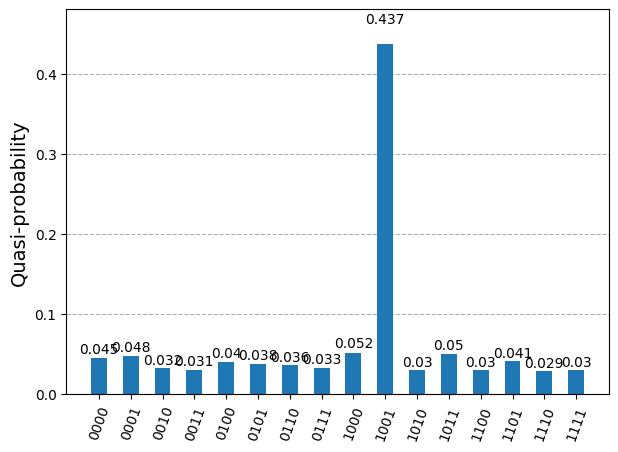

In [28]:
plot_distribution(dist)

Let's see how this looks like on simulator:

In [29]:
from qiskit.primitives import StatevectorSampler

sampler_simulator = StatevectorSampler()

num_shots = 1000000
pm = generate_preset_pass_manager(optimization_level=1)
isa_circuit_simulator = pm.run(qc)
result = sampler_simulator.run([isa_circuit_simulator], shots=num_shots).result()
data_pub = result[0].data
counts = data_pub.meas.get_counts()

for i in counts:
    counts[i] = float(counts[i]/num_shots)

print(f"The probabilities are: {counts}")

The probabilities are: {'1001': 0.961216, '1100': 0.002503, '0011': 0.002532, '0000': 0.002532, '1000': 0.002592, '0101': 0.002588, '1010': 0.002556, '1111': 0.002657, '0001': 0.002529, '0111': 0.00255, '0110': 0.002685, '0010': 0.002652, '1011': 0.002574, '1101': 0.002615, '0100': 0.002628, '1110': 0.002591}


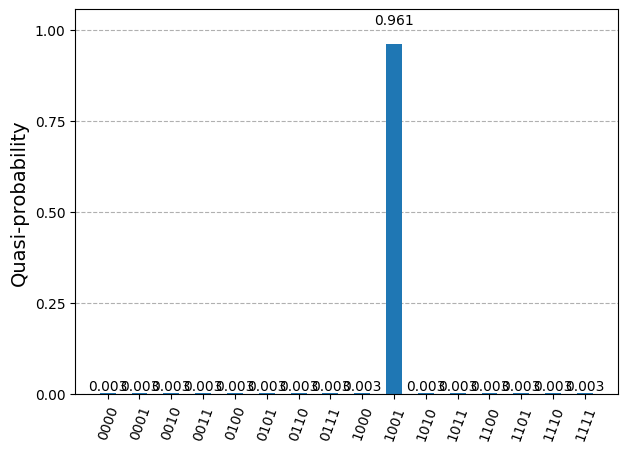

In [30]:
plot_distribution(counts)

much better :)